# Unsupervised Text Clustering

In this notebook, we will cluster text from a news dataset using multiple methods. We demonstrates how to preprocess text data and build a Machine Learning (ML) model in order to cluster the data. You will use the [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset), which contains approximately 200k news headlines from the years 2012 to 2018 obtained from [The Huffington Post](https://www.huffingtonpost.com/).

We will use different methods of preprocessing and different ML models in order to cluster data.

This notebook is part of my [ML series](https://github.com/bryanlusse/ml-projects).

&copy; Bryan Lusse - 2022

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import sklearn
import random

# Progress bars
from tqdm.auto import tqdm
tqdm.pandas()

# Text cleaning
import nltk
nltk.download('punkt') # one time execution
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
# Initializing of word lists
stop_words = set(stopwords.words('english'))
words = set(words.words())

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api

# ML models
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

# Visualization
from sklearn.decomposition import TruncatedSVD
import plotly.express as px
import matplotlib.pyplot as plt
# To ensure visibility of plots
import plotly.io as pio
pio.renderers.default = "iframe"

# Other
from sklearn.neighbors import NearestNeighbors
from random import randint
from collections import Counter
import time

[nltk_data] Downloading package punkt to /Users/bryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/bryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/bryan/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Load data
The data is saved as a _.json_ file. We can read this using Pandas

In [2]:
data = pd.read_json('data/news_data.json', lines=True)
data

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


## EDA
We start with an Exploratory Data Analysis (EDA) in order to get a better feel of the data

In [3]:
print('Data consists of ' + str(data.shape[0]) + ' headlines')

Data consists of 200853 headlines


The data is already sorted in news categories. These are the following:

In [4]:
data['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

The distribution of these categories looks like the following:

As we see, there is a high amount of articles on politics. This should be a group our model will probably cluster well on.

<AxesSubplot:>

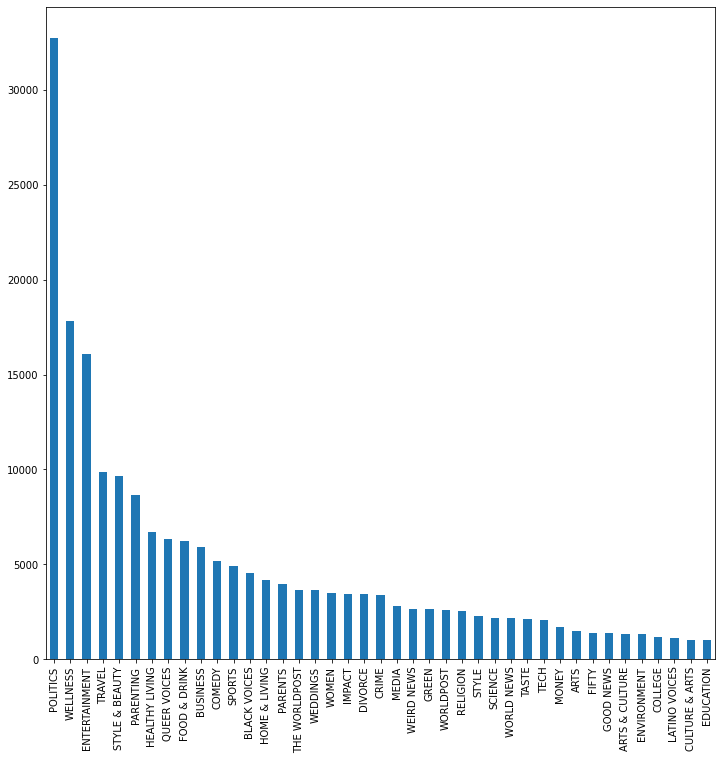

In [5]:
data['category'].value_counts().plot(kind='bar', figsize=(12,12))

The distribution of the publication dates is very consistent over all years

array([[<AxesSubplot:title={'center':'date'}>]], dtype=object)

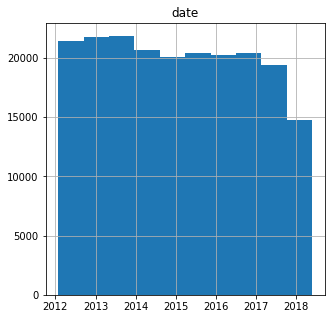

In [6]:
data.hist('date', figsize=(5,5))

From here on out, we only select the headlines to cluster these

In [7]:
df = pd.DataFrame(data['headline'])
df

,headline
0,There Were 2 Mass Shootings In Texas Last Week...
1,Will Smith Joins Diplo And Nicky Jam For The 2...
2,Hugh Grant Marries For The First Time At Age 57
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,Julianna Margulies Uses Donald Trump Poop Bags...
...,...
200848,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,Maria Sharapova Stunned By Victoria Azarenka I...
200850,"Giants Over Patriots, Jets Over Colts Among M..."
200851,Aldon Smith Arrested: 49ers Linebacker Busted ...


## Preprocessing
Preprocessing is vital in order to extract meaningful information from text data. This is because there are many intrecies in our language that are difficult for machines to pick up on. It is easiest to condense text to their most basic and pure meaning. There are multiple techniques for this:

- **Removing stop words**

    Some words in our language do not hold much information and are used very often. Take words like 'the', 'you' or 'too' do not hold much information on their own. Therefore we can remove these to be left with words that carry meaning.
   

- **Removing punctuation**

    It is easier for our model to not have to worry about punctuation. With added punctuation similar words will have to be encoded as having a different meaning -> 'hello' will not be the same as 'hello!'. In order to keep the data easier for our model, we remove punctuation. 
    
    
- **Lemmatization**

    Lemmatization is the process of grouping together different forms of a word. The aim of this process is to remove suffixes and prefixes in order to bring out the dictionary form of the word. As an example, presences of the words 'studies' and 'studying' will both be transformed into 'study'.
    

- **Removing contractions**

    This will not be used in this notebook, but another important step in preprocessing for text data is removing contractions. Contractions like "you're" or "they're" are prevalent in messaging or email datasets. Removing these contractions contributes to text standardization as fully written words are present.

In our notebook, we will use the _nltk_ library, which is an often used library for natural language processing.

In [8]:
def clean_non_english(txt):
    txt = re.sub(r'\W+', ' ', txt)
    txt = txt.lower()
    txt = txt.replace("[^a-zA-Z]", " ")
    word_tokens = word_tokenize(txt)
    filtered_word = [w for w in word_tokens if w in words]
    filtered_word = [w for w in filtered_word if not w in stop_words]
    filtered_word = [w for w in filtered_word if all(ord(c) < 128 for c in w)]
    filtered_word = [w + " " for w in filtered_word]
    return "".join(filtered_word)

def remove_mentions_hashtags(txt):
    message = []
    for i in txt.split(" "):
        if len(i) > 0 and i[0] == "@":
            pass
        elif len(i) > 0 and i[0] == '#':
            pass
        else:
            message.append(i)
    return " ".join(message)

In [9]:
df['headline']

0         There Were 2 Mass Shootings In Texas Last Week...
1         Will Smith Joins Diplo And Nicky Jam For The 2...
2           Hugh Grant Marries For The First Time At Age 57
3         Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4         Julianna Margulies Uses Donald Trump Poop Bags...
                                ...                        
200848    RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849    Maria Sharapova Stunned By Victoria Azarenka I...
200850    Giants Over Patriots, Jets Over Colts Among  M...
200851    Aldon Smith Arrested: 49ers Linebacker Busted ...
200852    Dwight Howard Rips Teammates After Magic Loss ...
Name: headline, Length: 200853, dtype: object

In [10]:
df['headline'] = df['headline'].progress_apply(remove_mentions_hashtags)

In [11]:
df['headline']

0         There Were 2 Mass Shootings In Texas Last Week...
1         Will Smith Joins Diplo And Nicky Jam For The 2...
2           Hugh Grant Marries For The First Time At Age 57
3         Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4         Julianna Margulies Uses Donald Trump Poop Bags...
                                ...                        
200848    RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849    Maria Sharapova Stunned By Victoria Azarenka I...
200850    Giants Over Patriots, Jets Over Colts Among  M...
200851    Aldon Smith Arrested: 49ers Linebacker Busted ...
200852    Dwight Howard Rips Teammates After Magic Loss ...
Name: headline, Length: 200853, dtype: object

In [12]:
df['headline'] = df['headline'].progress_apply(clean_non_english)

In [13]:
df['headline']

0                                  mass last week 
1         smith nicky jam world cup official song 
2                            grant first time age 
3                                             new 
4                             trump poop pick dog 
                            ...                   
200848                 rim significant blackberry 
200849                           maria open final 
200850           among improbable super bowl time 
200851                               smith busted 
200852                                 magic loss 
Name: headline, Length: 200853, dtype: object

In [14]:
nan_value = float("NaN") #Convert NaN values to empty string.
df = df.replace("", nan_value)
df = df.dropna(subset = ["headline"])

In [15]:
df

,headline
0,mass last week
1,smith nicky jam world cup official song
2,grant first time age
3,new
4,trump poop pick dog
...,...
200848,rim significant blackberry
200849,maria open final
200850,among improbable super bowl time
200851,smith busted


In [16]:
print('By preprocessing we have removed {0} out of {1} headlines'.format((data.shape[0]-df.shape[0]), data.shape[0]))

By preprocessing we have removed 1814 out of 200853 headlines


In [17]:
df.to_csv('outputs/preprocessed.csv')

In [18]:
df = pd.read_csv('outputs/preprocessed.csv', index_col=0)
df

,headline
0,mass last week
1,smith nicky jam world cup official song
2,grant first time age
3,new
4,trump poop pick dog
...,...
200848,rim significant blackberry
200849,maria open final
200850,among improbable super bowl time
200851,smith busted


## Vectorization
The initial set of raw data has currently been reduced to a more manageable dataset. From here, another step is necesarry, as we cannot feed raw text into a model that only works with numbers to calculate. We need a method to transform the data from textual to numerical, and this is where vectorization comes in.

Vectorization turns a piece of text into a vector containing numbers. There are many different methods to do this.
From here on, we explain four different methods to perform vectorization:

### Bag-of-Words

This method is simple and flexible, and it can be used in a variety of ways to retrieve information from text.

A bag-of-words (BoW) represents text by indicating how often words appear in a text. It involves the following steps:

- Constructing a vocabulary of commonly used words in the text.
- Determining the presence of commonly used words.

This method is referred to as a "bag" of words because all the model is concerned with is wether or not certain terms appear in the document. It does not take any information about the sequence or structure of words into account. 

The underlying assumption in this method is that texts containing similar words are also similar.

**Pro's:**
- Simple

**Con's:**
- Only bases itself on occurence of words, and does not capture semantics or position in text

Below we see an example of a simple BoW representation

![image](assets/bow.jpeg)

[Image source](https://maelfabien.github.io/machinelearning/NLP_2/#1-bag-of-words)

In [19]:
bow_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
# tokenize and build vocab
bow_vectorizer.fit(df['headline'])
# Create a Vocabulary
# The vocabulary establishes all of the possible words we might use.
bow_matrix = bow_vectorizer.transform(df['headline'])

### TF-IDF

One problem with using word frequencies is that highly frequent words tend to dominate the document. However, these words might not contain as much "information" to the model as less frequent words. One way to improve the quality of the results is to penalize frequent words that are common across all documents.

This approach to scoring is called Term Frequency – Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: This is an algorithm that assigns a score to each word in a document based on its frequency within the document (within the headline in our case).

-  **Inverse Document Frequency**: This is an algorithm which assigns a score to each term based on how common it is across all documents (all headline in our case). These scores are then used to determine the importance of each word. 

The scores highlight words that are distinct (i.e. are useful) in a given document.

**Pro's:**
- Takes into account that frequent words may not give too much information

**Con's:**
- Does not capture semantics or position in text

![image](assets/tf-idf.png)

[Image source](https://medium.com/codex/document-indexing-using-tf-idf-189afd04a9fc)

In [20]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))

# Generate matrix of word vectors
tfidf_matrix = Tfidf_vectorizer.fit_transform(df['headline'])

### Hashing

This method use the _hashing_ trick in order to construct vectors from text data. This trick consists of using a function . For more information see this [link](https://en.wikipedia.org/wiki/Feature_hashing).

**Pro's:**

- It uses a very small amount of memory as there is no need to store a vocabulary of words.

- It is fast.

**Con's:** 

- There is no way to compute the inverse transform (from feature indices to string feature names) which can be a problem when trying to analyse which features are most important to a model.

![image](assets/hashing.png)

[Image source](https://kavita-ganesan.com/hashingvectorizer-vs-countvectorizer/#.YrPExOzP23I)


In [21]:
hash_vectorizer = HashingVectorizer(n_features=2**5)
hash_matrix = hash_vectorizer.fit_transform(df['headline'])

### Word2Vec

Word2Vec uses a trained neural network in order to convert words into vectors. Due to its extensive training on a wide variety of words, it excels at providing numerical representations for words that are related to one another.


In the image below we see an illustration of several words and their vectorized representation being plotted. Some of these words are similar, and also are plotted close to one another. This shows the great strength of Word2Vec.

**Pro's:**

- Uses a trained neural network to calculate word vectors and therefore captures word similarity very well.

**Con's:** 

- Takes longer to compute as the computations are not trivial.

![image](assets/word2vec.png)

[Image source](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)

In [22]:
wv = api.load('word2vec-google-news-300')

In [23]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in tqdm(list_of_docs):
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
w2v_matrix = vectorize(df['headline'], model=wv)

  0%|          | 0/199039 [00:02<?, ?it/s]

In [24]:
X_vectorized = [bow_matrix, tfidf_matrix, hash_matrix, w2v_matrix]
names = ['BoW', 'TFIDF', 'Hash', 'W2V']

## Modelling

### K-Means Clustering

The K-Means algorithm clusters data by separating the data points into *k* groups of equal variance and hereby minimizes the inertia or [within-cluster sum-of-squares](https://en.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance).

During the modelling process, cluster centers are calculated. Dependent on the distance from these centers, data points are added or removed from clusters, which in turn changes the location of the centers. This process continues untill convergence in order to end up with well defined clusters.

The variable 'k' signifies the amount of clusters, and therefore cluster centers that are initially created.

**Pro's:**

- The model scales well with medium to large datasets
- K-Means clustering has been used many different applications in a plethora of different fields.

**Con's:** 

- The within-cluster sum-of-squares critertion assumes convex and isotropic clusters. This is not always the case, K-Means clustering will therefore have a hard time with recognizing irregularly-shaped clusters.


![image](assets/kmeans.png)


[Image source](https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/)

As with the K-Means model we can define the number of clusters on our own, we vary this number. We did experiments. with the number of clusters ranging from 5 to 50 (The number of categories in the original dataset is 41).

In [25]:
k_list = [5,10,15,20,25,30,35,40,45,50]

kmeans_bow = []
kmeans_tfidf = []
kmeans_hash = []
kmeans_w2v = []
sse_bow = []
sse_tfidf = []
sse_hash = []
sse_w2v = []

for k in tqdm(k_list, total=len(k_list)):
    for vectorized_data, name in zip(X_vectorized, names):
        model = KMeans(k, random_state=123, init='k-means++')

        output = model.fit(vectorized_data)

        if name == 'BoW':
            sse_bow.append(output.inertia_)
            np.save('outputs/'+name+'_kmeans_'+str(k), output.labels_)
        elif name == 'TFIDF':
            sse_tfidf.append(output.inertia_)
            np.save('outputs/'+name+'_kmeans_'+str(k), output.labels_)
        elif name == 'Hash':
            sse_hash.append(output.inertia_)
            np.save('outputs/'+name+'_kmeans_'+str(k), output.labels_)
        else:
            sse_w2v.append(output.inertia_)
            np.save('outputs/'+name+'_kmeans_'+str(k), output.labels_)

  0%|          | 0/10 [00:00<?, ?it/s]

### DBSCAN

The DBSCAN algorithm views data as a combination of high density area's (the clusters) and low-density area's (the space in between). Because this criterion has minimal assumptions about the actual cluster shape, the clusters can be of any shape or form (e.g. they do not need to be circular). This leads to the DBSCAN algorithm performing better than the K-means algorithm in several occasions (see image below). 

The algorithm finds dense area's (clusters) if a point has a minimum number of neighbours within a predefined distance. The amount of neighbours is given to the model using the *min_samples* variable and the distance is given through the *eps* variable. It is important to investigate the data in order to find correct values for. these vartiables.

**Pro's:**

- The DBSCAN algorithm can identify clusters of any size
- The algorithm does not need a predefined number of clusters

**Con's:** 

- Determining the correct values for *eps* and *min_samples* can be difficult and very domain-specific

![image](assets/dbscan_vs_kmeans.png)

[Image source](https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html)

To optimize the DBSCAN algorithm, we can investigate the distance between all datapoints. This aids us in establishing a correct value for *eps*.  

If we plot the distance between points versus the number of datapoints, the optimal value for the *eps* parameter can be found at the point of maximum curvature. This point is the breaking point between high density and low density regions. Below, we plot these distance curves for all four vectorized datasets.

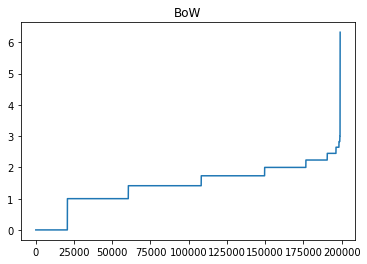

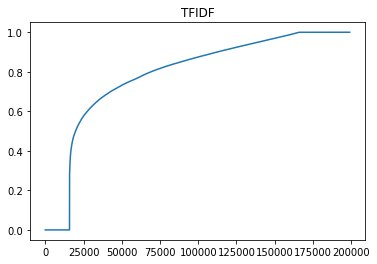

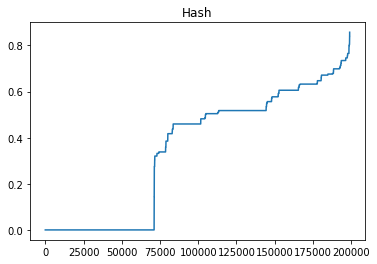

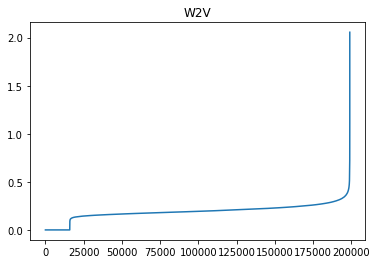

In [26]:
for matrix, name in zip(X_vectorized, names):
    neigh = NearestNeighbors(n_neighbors=20)
    nbrs = neigh.fit(matrix)
    distances, indices = nbrs.kneighbors(matrix)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.xlabel = 'Number of datapoints'
    plt.ylabel = 'Distance'
    plt.title(name)
    plt.show()

Using the values for *eps* that we got from the graphs, we fit the models. Additionally, min_samples is set to 100 in order to not end up with clusters that are too small.

In [27]:
dbscan_bow = []
dbscan_tfidf = []
dbscan_hash = []
dbscan_w2v = []
eps_list = [1.0, 0.1, 0.1, 0.4]

for eps, vectorized_data, name in tqdm(zip(eps_list, X_vectorized, names), total=len(X_vectorized)):
    model = DBSCAN(eps=eps, min_samples=100)
    output = model.fit(vectorized_data)
    
    if name == 'BoW':
        dbscan_bow.append(output)
        np.save('outputs/'+name+'_dbscan_', output.labels_)
    elif name == 'TFIDF':
        dbscan_tfidf.append(output)
        np.save('outputs/'+name+'_dbscan_', output.labels_)
    elif name == 'Hash':
        dbscan_hash.append(output)
        np.save('outputs/'+name+'_dbscan_', output.labels_)
    else:
        dbscan_w2v.append(output)
        np.save('outputs/'+name+'_dbscan_', output.labels_)

  0%|          | 0/4 [00:00<?, ?it/s]

## Evaluation
After fitting our model, we have to look at how our model has performed. 

### K-Means - Amount of clusters

As we have used multiple values for the number of clusters, now is a good time to compare results for these different values. We do this by comparing the inertia or [within-cluster sum-of-squares](https://en.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance). The idea behind this process is that at a point where, with increasing number of clusters, the inertia only reduces a small amount, we are at an optimal and efficient solution. Adding more clusters only complicates the. calculations, and if this leads to only a minimal gain in performance, this is negligible.

In practice, this means that when we plot the amount of clusters (k) versus the inertia, we are looking for the point from where the inertia only decreases slightly, famously known as the 'elbow' of the graph.

The graphs in question have been plotted below. In a few of these graphs, we can see a change in the decrease of the inertia around a number of 10 clusters. We pick this as our value of K.

Additonally, as our dataset was originally classified into 41 different categories, we also investigate results retrieved with k=40.

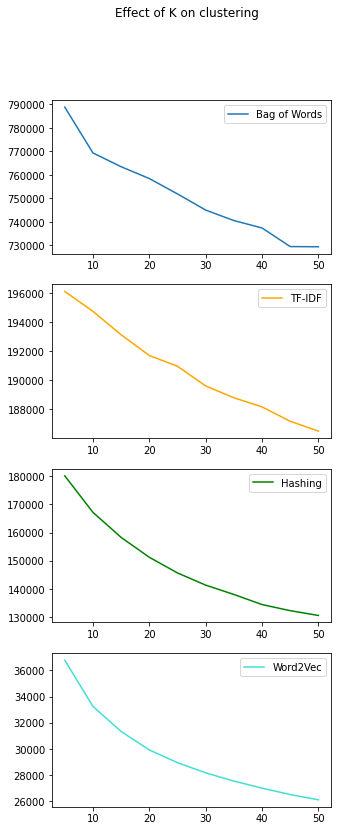

In [28]:
plt.figure(figsize=(5,13))
plt.suptitle('Effect of K on clustering')
plt.subplot(4,1,1)
plt.plot(k_list, sse_bow, label='Bag of Words')
plt.legend()
plt.subplot(4,1,2)
plt.plot(k_list, sse_tfidf, label='TF-IDF', color='orange')
plt.legend()
plt.subplot(4,1,3)
plt.plot(k_list, sse_hash, label='Hashing', color='green')
plt.legend()
plt.subplot(4,1,4)
plt.plot(k_list, sse_w2v, label='Word2Vec', color='turquoise')
plt.xlabel = 'K'
plt.legend()
plt.show()

### Silhouette Score
The Silhouette Coefficient is calculated using the mean intra-cluster distance *a*: the mean distance between the sample and other samples in its cluster, and the mean nearest-cluster distance *b*: the mean distance between the sample and the closest other cluster, for each sample. The Silhouette Coefficient for a sample is 

$$ S = {(b-a) \over \max(a,b)} $$

The image below visualises the discussed distances:

![Image](assets/silhouette.png)

In [29]:
optimal_k = ['10','40']

for k in optimal_k:
    print('K =', k)
    filenames = ['BoW_kmeans_', 'TFIDF_kmeans_', 'Hash_kmeans_', 'W2V_kmeans_', 'BoW_dbscan_', 'TFIDF_dbscan_', 'Hash_dbscan_', 'W2V_dbscan_']

    outputs_total = []
    for filename in filenames:
        if "kmeans" in filename:
            outputs_total.append(np.load('outputs/'+filename+k+'.npy'))
        else:
            outputs_total.append(np.load('outputs/'+filename+'.npy'))

    X_vectorized_looped = [bow_matrix, tfidf_matrix, hash_matrix, w2v_matrix, bow_matrix, tfidf_matrix, hash_matrix, w2v_matrix]

    combined_names = ['BoW - KMeans', 'TFIDF - KMeans', 'Hash - KMeans', 'Word2Vec - Kmeans', 'BoW - DBSCAN', 'TFIDF - DBSCAN', 'Hash - DBSCAN', 'Word2Vec - DBSCAN']

    for label, X, name in zip(outputs_total, X_vectorized_looped, combined_names):
        score = silhouette_score(X, label, metric='euclidean', sample_size=50000) # Use sample size as practically same answer as full data
        print('Silhouette Score ' + name + ': %.3f' % score)

K = 10
Silhouette Score BoW - KMeans: 0.013
Silhouette Score TFIDF - KMeans: 0.008
Silhouette Score Hash - KMeans: 0.062
Silhouette Score Word2Vec - Kmeans: 0.041
Silhouette Score BoW - DBSCAN: -0.073
Silhouette Score TFIDF - DBSCAN: -0.013
Silhouette Score Hash - DBSCAN: -0.266
Silhouette Score Word2Vec - DBSCAN: 0.422
K = 40
Silhouette Score BoW - KMeans: 0.027
Silhouette Score TFIDF - KMeans: 0.020
Silhouette Score Hash - KMeans: 0.061
Silhouette Score Word2Vec - Kmeans: 0.020
Silhouette Score BoW - DBSCAN: -0.073
Silhouette Score TFIDF - DBSCAN: -0.013
Silhouette Score Hash - DBSCAN: -0.269
Silhouette Score Word2Vec - DBSCAN: 0.425


### Comparing all models

For K=10, the silhouette scores look like the following:

|               | Model | K-Means | DBSCAN      |
|---------------|-------|---------|-------------|
| Vectorization |       |         |             |
| BoW           |       | 0.013   | -0.073      |
| TF-IDF        |       | 0.008   | -0.013      |
| Hashing       |       | 0.062   | -0.266      |
| Word2Vec      |       | 0.041   | <font color='red'>0.422</font> |

for K=40:

|               | Model | K-Means | DBSCAN      |
|---------------|-------|---------|-------------|
| Vectorization |       |         |             |
| BoW           |       | 0.027   | -0.073      |
| TF-IDF        |       | 0.020   | -0.013      |
| Hashing       |       | 0.061   | -0.269      |
| Word2Vec      |       | 0.020   | <font color='red'>0.425</font> |

Due to the nature of the Silhouette Score algorithm, the samples it takes from the data can differ slightly, making the calculated silhouette score slighty different. However, these differences are very small, and the calculated values in different iterations of the algorithm are very similar.

From the results above, we can see that the Word2Vec algorithm with DBSCAN clustering had the highest silhouette score.

### Visualization
To fully understand the clustering of our models, we visualize the performance of the best model and others

First,  we investigate the size of the clusters:

In [30]:
sizes = []
for i in list(set(outputs_total[-1])):
    sizes.append(np.sum(np.array(outputs_total[-1])==i))
size_df = pd.DataFrame({"Cluster": list(set(outputs_total[-1])), "Size": sizes}, index=None)
display(size_df.style.hide_index())
print("Total: ", np.sum(sizes))

Cluster,Size
0,191783
1,180
-1,7076


Total:  199039


Here we see that although this model led to the highest Silhouette score, it only clustered the data into two clusters (For DBSCAN noisy samples are given the label -1). Of which one encompasses more than 95% of the data. This is not at all what we would expect.

When we reduce the dimensionality of the data in order to plot it on a 2-Dimensional (2D) plane, we see that the data itself is relatively difficult to cluster. In 2D space we can't see any clear clusters. However, this does not mean that these also are not detectable on a higher dimensional scale. 

In the graph below we can see this 2D representation of all data points:

In [31]:
def plotCluster(nr):
    matrix = X_vectorized_looped[nr]
    output = outputs_total[nr]
    nr_clusters = len(list(set(outputs_total[nr])))

    svd = TruncatedSVD(n_components=2, random_state=42)
    data = svd.fit_transform(matrix) 

    plt.cm.get_cmap('terrain', nr_clusters+1) #
    colors = []
    for i in range(nr_clusters):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    labels = [str(x) for x in range(nr_clusters)]

    # DBSCAN creates a cluster for outliers
    if nr>3:
        labels[-1] = 'Outliers'

    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    vectorizer_label = np.vectorize(lambda x: labels[x])

    if nr>3:
        for i in range(-1,nr_clusters-1):
            color = colors[i]
            label = labels[i]
            points = output==i
            d = data[points]
            plt.scatter(d[:,0], d[:,1], c=color, label=label)
    else:
        for i in range(nr_clusters):
            color = colors[i]
            label = labels[i]
            points = output==i
            d = data[points]
            plt.scatter(d[:,0], d[:,1], c=color, label=label)
    plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.95),
              fancybox=True, shadow=True, ncol=int(np.ceil(nr_clusters/10)))

    plt.title("Clustering of news headlines by " + combined_names[nr] + ' Algorithm')
    plt.show()

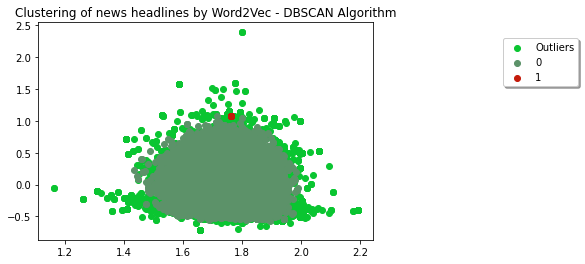

In [32]:
# Index of data
nr = 7
plotCluster(nr)

We see this behaviour in more clustering results from the DBSCAN algorithm. Below, we plot similar graphs for all models. We see that for the DBSCAN algorithm, only the hashing preprocessing technique led to a large amount of clusters. However, the noisy points still consist of a large fraction of the data points, making for very small clusters.

The results for models using K-Means are different, as here clusters seem more well spread. Most models still predict small clusters, but the model with Word2Vec vectorizations seems to have several bigger clusters.

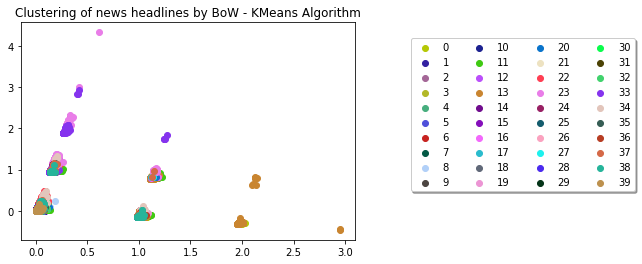

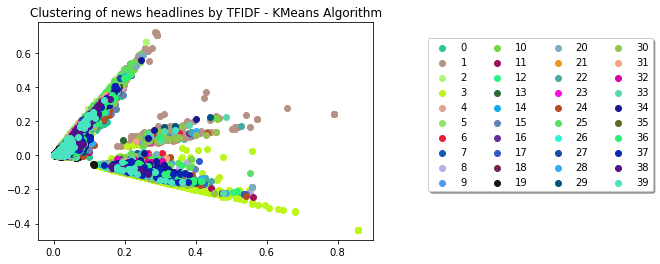

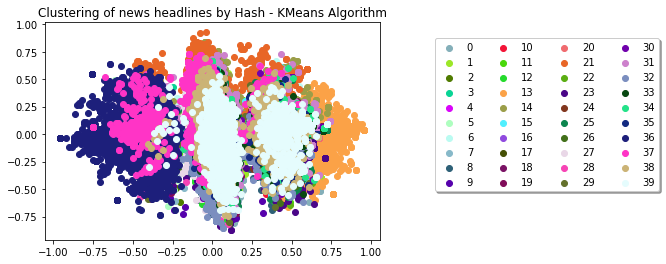

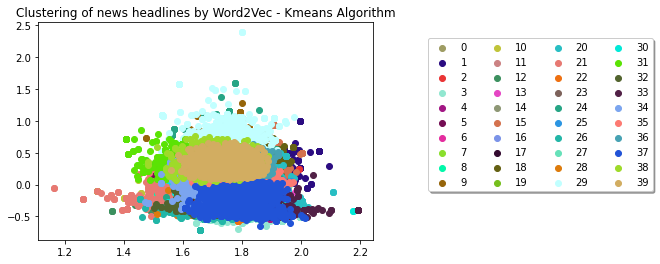

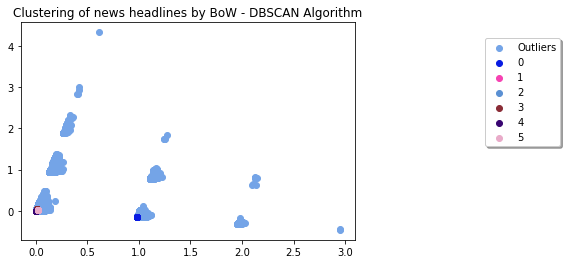

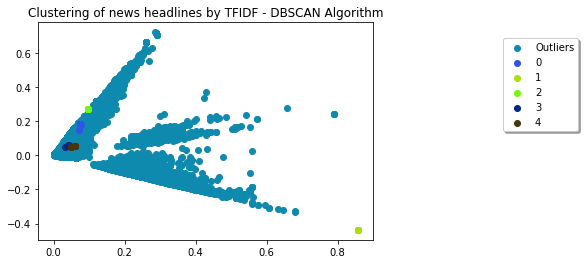

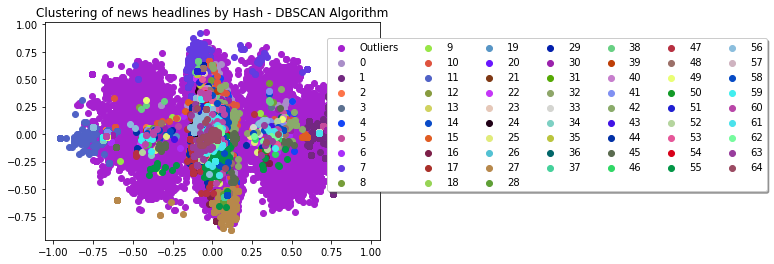

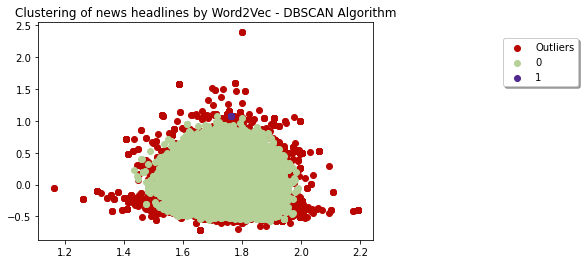

In [33]:
for j in range(len(outputs_total)):
    # Index of data
    nr = j

    plotCluster(nr)

We can analyse our results even further and visualize the most frequent words in a certain cluster. For this we use the function below.

In [34]:
def plotClustersWords(nr):
    ## Should not be used for hashing models. Could be updated to incorporate these
    
    matrix = X_vectorized_looped[nr]
    output = outputs_total[nr]
    nr_clusters = len(list(set(output)))

    svd = TruncatedSVD(n_components=2, random_state=42)
    data = svd.fit_transform(matrix) 

    plt.cm.get_cmap('terrain', nr_clusters+1) #
    colors = []
    for i in range(nr_clusters):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    labels = [str(x) for x in range(nr_clusters)]

    # DBSCAN creates a cluster for outliers
    if nr>4:
        labels[-1] = 'Outliers'

    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    vectorizer_label = np.vectorize(lambda x: labels[x])

    for i in range(nr_clusters):
        color = colors[i]
        label = labels[i]
        points = output==i
        d = data[points]
        plt.scatter(d[:,0], d[:,1], c=color, label=label)
    plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.95),
              fancybox=True, shadow=True, ncol=int(np.ceil(nr_clusters/10)))

    plt.title("Clustering of news headlines by " + combined_names[nr] + ' Algorithm')
    plt.show()

    #########################
    # Cluster Visualization #
    #########################

    print("Words per cluster")

    vectorizers = [bow_vectorizer, Tfidf_vectorizer, hash_vectorizer, '', bow_vectorizer, Tfidf_vectorizer, hash_vectorizer, '']
    # Different colourmaps for different clusters
    colors = ['pinkyl','tempo','magenta','amp','blues','algae','ice','picnic','electric','sunset']
    
    if nr_clusters > 10:
        graph_clusters = 10
    else:
        graph_clusters = nr_clusters

    # If model is Word2Vec the analysis is slightly different 
    if nr == 3 or nr == 7:
        # Create dataframe with all words and their clusters
        df_clusters_w2v = pd.DataFrame({
            "tokens": [text for text in df['headline']],
            "cluster": outputs_total[nr]
        })

        for n in range(graph_clusters): 

            word_list = [word for line in df_clusters_w2v[df_clusters_w2v['cluster']==n]['tokens'].tolist() for word in line.split()]
            # Count amount of words for a certain cluster
            counts = Counter(word_list)

            word_freq = pd.DataFrame(dict(counts).items(), columns=['word', 'frequency']).sort_values('frequency', ascending=False)
            word_freq.reset_index(level=0, inplace=True)
            word_freq.drop(index=[0],inplace=True)

            fig = px.treemap(word_freq[0:30], path=[px.Constant(labels[n]),'word'], values='frequency',
                        color='frequency', hover_data=['frequency'],
                        color_continuous_scale= colors[n])
            fig.show()
            time.sleep(1) # Necessary to stop plotting of data from previous cluster

    # For all other models
    else:
        matrix_df = pd.DataFrame.sparse.from_spmatrix(matrix)

        # Map the column names to vocabulary 
        matrix_df.columns = vectorizers[nr].get_feature_names_out()
        matrix_df['cluster'] = pd.DataFrame(output)

        for n in range(graph_clusters):    
            word_freq = pd.DataFrame(matrix_df[matrix_df.cluster == n].sum().sort_values(ascending = False))
            word_freq.reset_index(level=0, inplace=True)
            word_freq.columns=['word','frequency']

            if n>0:
                word_freq.drop(index=[0],inplace=True)

            fig = px.treemap(word_freq[0:30], path=[px.Constant(labels[n]),'word'], values='frequency',
                        color='frequency', hover_data=['frequency'],
                        color_continuous_scale= colors[n])
            fig.show()

When we look at frequently occuring words in the clusters from the model with Bag of Words vectorization and K-Means clustering, we see that the words in the clusters do not always make sense to be grouped together. Sometimes unrelated words are together, but also several words are present in multiple clusters. However, cluster 5 seems to contain many words related to Donald Trump and presidency, still showing accurate results (these unfortunately do not show but are saved in the *iframe_figures* folder, or you can run the code yourself).

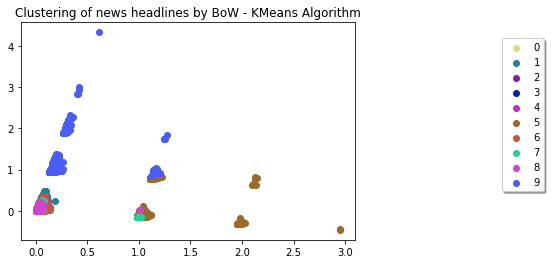

Words per cluster


In [35]:
# Index of data
nr = 0 # Bag of Words - K-Means
plotClustersWords(nr)

If we do the same analysis on the K-Means model with Word2Vec vectorization, we see similar results where there is not a strong theme in each cluster.

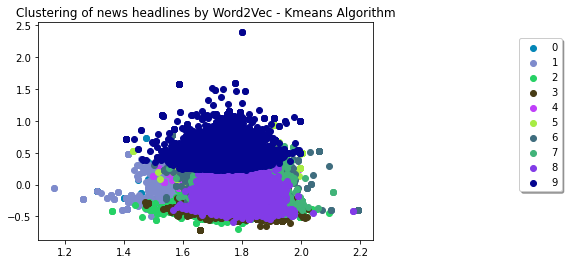

Words per cluster


In [36]:
nr = 3 # Word2Vec - K-Means
plotClustersWords(nr)

In general, the models we have analysed until now do cluster similar words to some degree, but do not cluster words into clear themes.

Interestingly enough, one of our other models did succeed in getting a cluster that encompasses the same information as one of the original categories of the data. The results below show that in the last shown cluster for the K-Means algorithm with BoW preprocessing and a K of 40, the main subject was *Wedding*. Clustering words such as, *couple*, *bride*, *cake* and *dress* (Run for yourself or see *iframe_figures/figure_13.html*)

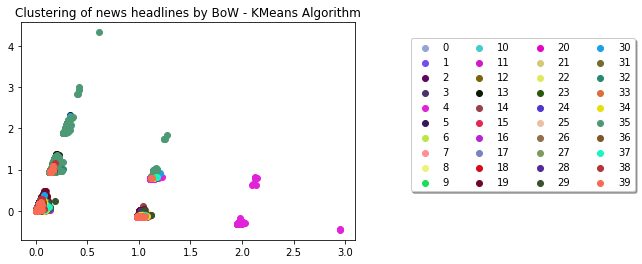

Words per cluster


In [37]:
# Index of data
nr = 0
k = '40'

outputs_total = []
for filename in filenames:
    if "kmeans" in filename:
        outputs_total.append(np.load('outputs/'+filename+k+'.npy'))
    else:
        outputs_total.append(np.load('outputs/'+filename+'.npy'))

plotClustersWords(nr)

## Conclusion

In this example, K-Mean models led to the best results. This is due to the versatility of the model, and the use of a predetermined number of clusters. In multiple cases, the DBSCAN algorithm struggled to find multiple clusters and/or clustered a multitude of data as noisy outliers. This shows the difficulty of using DBSCAN in practice. The hyperparameters truly need to be optimised to the task at hand, and the density of the samples is necesarry for DBSCAN.

Determining which preprocessing method worked best is difficult in this case, as we do not have an objective measure to compare the models and their results with. In unsupervised text clustering, multiple methods should be used and compared on a case-to-case basis.

We experienced that it remains difficult to objectively compare unsupervised methods. Models that give clusterings with a high silhouette score don't necessarily cluster similar words together more often.
This shows the most important thing to consider when using an unsupervised method: Human quality control. It is very important to double check your results in order to make sure these make sense. There are no ground-truth labels we can hold on to, so our own vision and domain knowledge need to be used.

Regardless, unsupervised learning is still a great way of learning from large datasets without ground-truth labels. Or additionally, a great way of clustering together data in order to define a plan of action for which part of the data has the highest priority for further analysis.

However, to actively group new data into the existing ground-truth clusters, a classification model should be used.

I hope you enjoyed coming along on this text clustering adventure! For other notebooks with machine learning tutorials go [here](https://github.com/bryanlusse/ml-projects)

👋